In [2]:
import numpy as np
import pandas as pd
from lstm_functions import *
from lost_functions import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

# <a id='toc1_'></a>[This to try to tune and try to get a good prediction for Apple Stock](#toc0_)
If i can get a good prediction for Apple Stock, then i can use the same model for other stocks  
This notebook is mainly to tune the model and get a good prediction for Apple Stock

# <a id='toc2_'></a>[Reading and storing the Data](#toc0_)

In [19]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["AAPL"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    new_data = data.resample('M').last().reset_index()
    new_data = new_data[new_data['Date'] < '2019-12-01']
    all_data[sheet] = new_data

In [22]:
all_data["AAPL"].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sector',
       'Ticker'],
      dtype='object')

<Axes: >

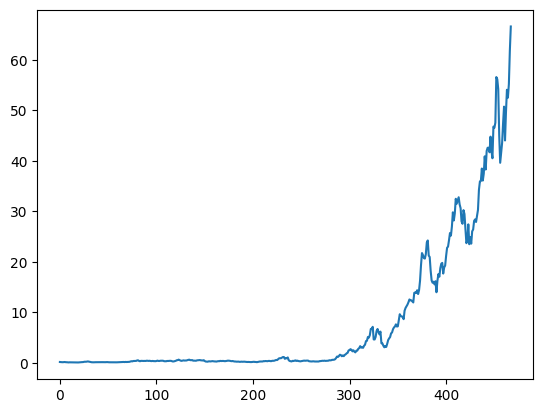

In [23]:
all_data["AAPL"]["Open"].plot()

In [24]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 12
features = 6

In [7]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    print(f"\nEvaluation for {ticker} on {feature}:")
    print(f"Training MAE: {train_mae}, Testing MAE: {test_mae}")
    print(f"Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}\n")
    return train_mae, test_mae, train_rmse, test_rmse


In [8]:
def plot_predictions(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    plt.figure(figsize=(14,7))
    plt.plot(y_train, label="Actual Train Values", color='blue')
    plt.plot(train_predictions, label="Predicted Train Values", color='blue', linestyle='dashed')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label="Actual Test Values", color='red')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label="Predicted Test Values", color='red', linestyle='dashed')
    plt.title(f"{ticker} {feature} - Actual vs Predicted Values")
    plt.legend()
    plt.show()


433 23
433 23
Working on: AAPL


2023-09-20 13:08:48.396417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:08:58.267418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 188ms/step


2023-09-20 13:14:20.891886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted value for AAPL: [ 3.5791451e+01  8.2872009e+01  8.7993210e+01  1.4179794e+01
  6.9892883e+01 -6.5906381e+09]
Importance value for AAPL: -2.2115731239318848
1/1 [==============================] - 0s 87ms/step

Evaluation for AAPL on Open:
Training MAE: 1.3418420771562751, Testing MAE: 20.488294352655824
Training RMSE: 3.2520995567390765, Testing RMSE: 21.223297244351407



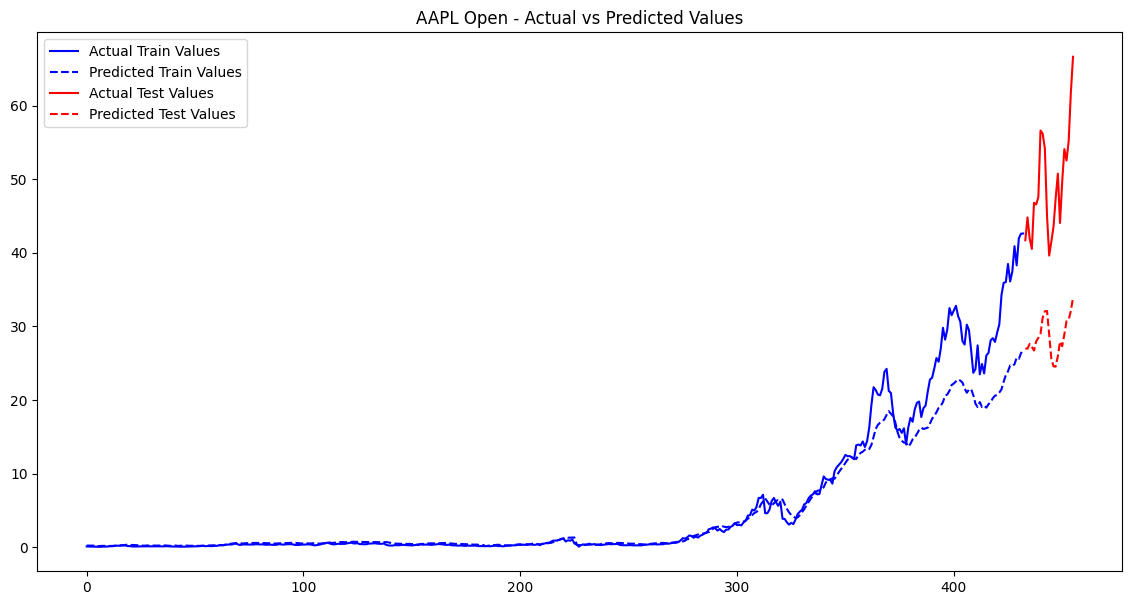


Evaluation for AAPL on High:
Training MAE: 0.753182420003772, Testing MAE: 13.661988133969514
Training RMSE: 1.874711662098395, Testing RMSE: 14.957431440683647



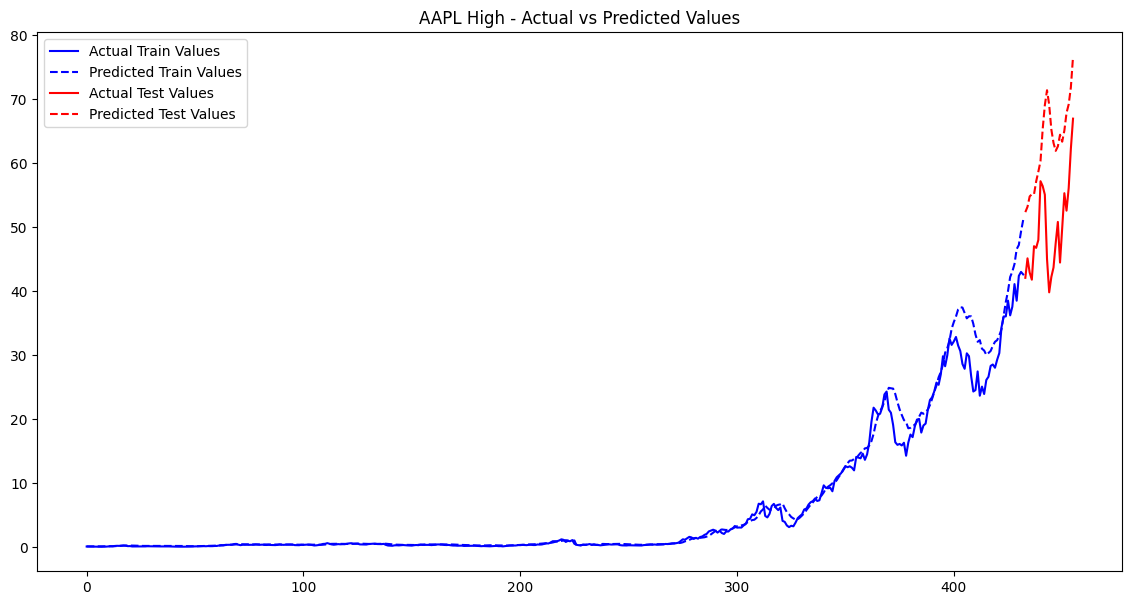


Evaluation for AAPL on Low:
Training MAE: 0.7900542780664465, Testing MAE: 16.742766670558762
Training RMSE: 1.9496914308977482, Testing RMSE: 17.804205488493512



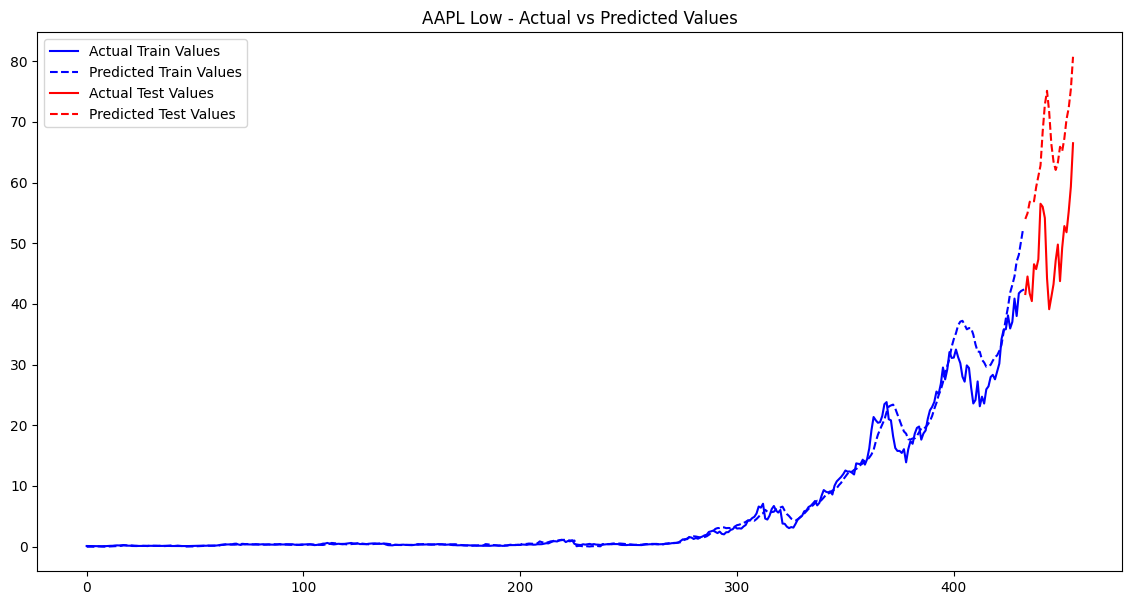


Evaluation for AAPL on Close:
Training MAE: 1.9886466338542261, Testing MAE: 35.05399256167205
Training RMSE: 5.000596973083875, Testing RMSE: 35.71698387468562



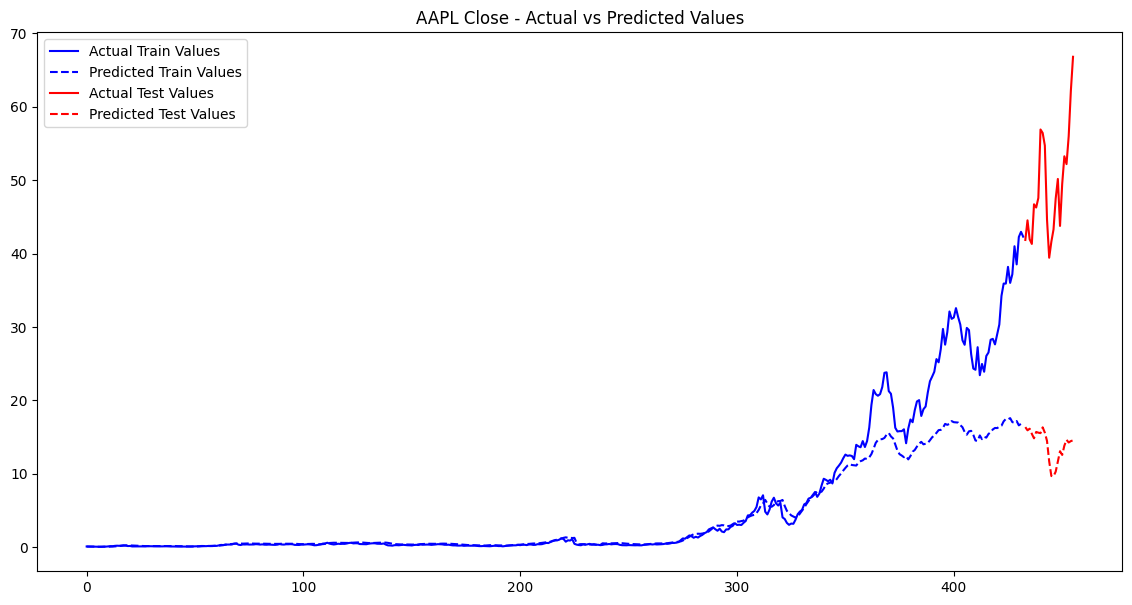


Evaluation for AAPL on Adj Close:
Training MAE: 0.5056547699302574, Testing MAE: 4.940884465756622
Training RMSE: 1.1781957970872898, Testing RMSE: 6.727228186802316



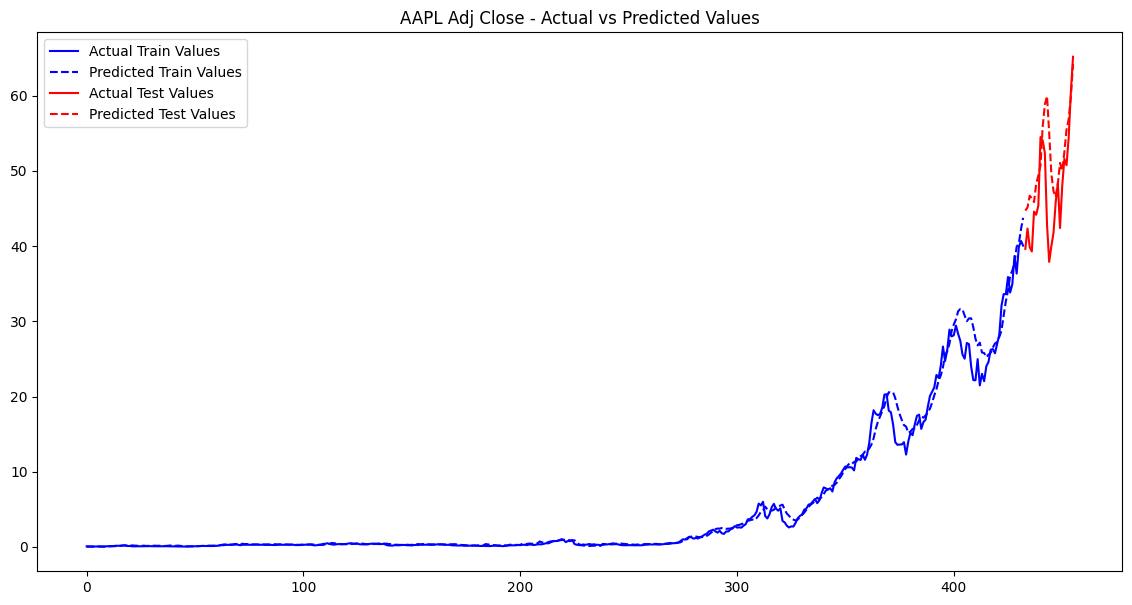


Evaluation for AAPL on Volume:
Training MAE: 334570326.5635104, Testing MAE: 4885075465.73913
Training RMSE: 684422811.5276204, Testing RMSE: 4948468315.899922



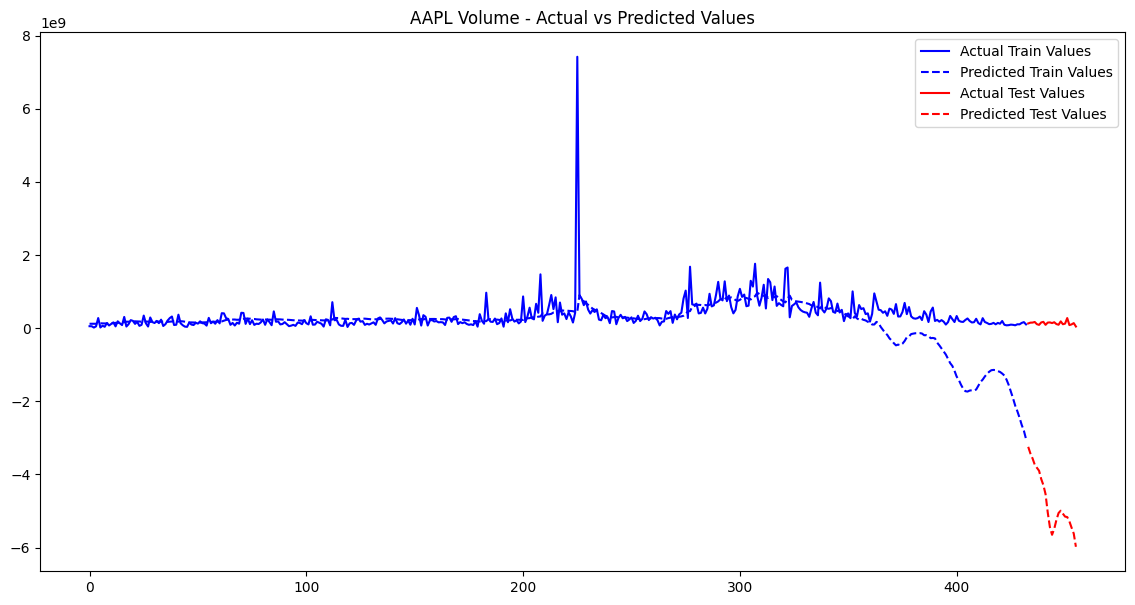

In [25]:
ticker = "AAPL"
data = all_data[ticker]

# Drop non-numeric columns
data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
model = lstm_model.create_model(features=features)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
X, y = lstm_model.create_sequences(normalized_data)
X_train, X_test, y_train, y_test = lstm_model.split_data(X,y, size=0.95)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

print("Working on: " + ticker)  
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Predict the next day value
last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
prediction_next_day = model.predict(last_days)
prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
final_predictions[ticker] = prediction_next_day_actual.flatten()
print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")


# Extracting importance
dense_weights = model.layers[-1].get_weights()[0]

# Think about to use sum or mean and to use abs() or not
feature_weights = dense_weights.sum(axis=0)
weighted_importance = prediction_next_day.flatten() * feature_weights
final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
print(f"Importance value for {ticker}: {final_importance_value}")

# Store the importance value in the dictionary
final_importance_values[ticker] = final_importance_value

# Predict for both training and testing data
train_predictions = scaler.inverse_transform(model.predict(X_train))
test_predictions = scaler.inverse_transform(model.predict(X_test))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
features_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for feature_index, feature_name in enumerate(features_list):
    # Extracting data for the specific feature
    y_train_feature = y_train[:, feature_index]
    y_test_feature = y_test[:, feature_index]
    train_predictions_feature = train_predictions[:, feature_index]
    test_predictions_feature = test_predictions[:, feature_index]

    # Evaluating the model for this feature
    evaluate_model(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)

    # Plotting the results for this feature
    plot_predictions(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)


In [ ]:
final_importance_values

{'XOM': -24.02027,
 'SHW': 5.5614214,
 'UPS': 5.2308617,
 'DUK': -5.3437276,
 'UNH': 0.14171359,
 'JPM': 8.934374,
 'AMZN': 2.0873442,
 'AAPL': 0.16826911,
 'META': 1.3775032,
 'AMT': -2.9676592}